In [1]:
# Step 1: Import Libraries
import pandas as pd
import xml.etree.ElementTree as ET
import os
import re
import xmltodict

def xml_to_dict(element):
    """Recursively converts an XML element and its children to a dictionary."""
    if len(element) == 0:
        return element.text
    return {child.tag: xml_to_dict(child) for child in element}

def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

In [2]:
# Step 2: Load and Parse XML Data using pandas.read_xml
def load_performance_data(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()
    print("Loading PP data for: ", os.path.basename(file_path))

    # Extract date from filename
    date_match = re.search(r'\d{8}', os.path.basename(file_path))
    race_date = ""
    if date_match:
        race_date = date_match.group(0)

    # Extract track from filename
    track_name = os.path.basename(file_path).split('_')[0][-3:]
    
    # Extract each Race element within EntryRaceCard and convert to a dictionary
    races = []
    for race in root.findall('.//Race'):
        race_dict = xmltodict.parse(ET.tostring(race))['Race']
        race_id = f"{race_date}_{race_dict['RaceNumber']}_{track_name}"
        race_date = race_date
        for entry in race.findall('.//Starters'):
            entry_dict = xmltodict.parse(ET.tostring(entry))['Starters']
            entry_dict['race_id'] = race_id
            entry_dict['race_date'] = race_date
            entry_dict['horse_id'] = f"{entry_dict['Horse']['HorseName']}_{entry_dict['ProgramNumber']}"
            races.append(entry_dict)
        
    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(races)

    return df

performance_path = "C:\\Users\\dylan\\OneDrive - Wayne State College\\Documents\\Equibase Data 2023\\2023 PPs\\Extracted PPs"
file_suffixes = ['PRM_USA.xml', 'CBY_USA.xml', 'FON_USA.xml']  # Add your suffixes here

# Load all past performance files
performance_data = pd.concat([load_performance_data(os.path.join(root, file)) 
                              for root, _, files in os.walk(performance_path) 
                              for file in files if file.endswith(tuple(file_suffixes))])

Loading PP data for:  SIMD20230210FON_USA.xml
Loading PP data for:  SIMD20230211FON_USA.xml
Loading PP data for:  SIMD20230212FON_USA.xml
Loading PP data for:  SIMD20230217FON_USA.xml
Loading PP data for:  SIMD20230218FON_USA.xml
Loading PP data for:  SIMD20230219FON_USA.xml
Loading PP data for:  SIMD20230224FON_USA.xml
Loading PP data for:  SIMD20230225FON_USA.xml
Loading PP data for:  SIMD20230226FON_USA.xml
Loading PP data for:  SIMD20230303FON_USA.xml
Loading PP data for:  SIMD20230304FON_USA.xml
Loading PP data for:  SIMD20230305FON_USA.xml
Loading PP data for:  SIMD20230310FON_USA.xml
Loading PP data for:  SIMD20230311FON_USA.xml
Loading PP data for:  SIMD20230312FON_USA.xml
Loading PP data for:  SIMD20230317FON_USA.xml
Loading PP data for:  SIMD20230318FON_USA.xml
Loading PP data for:  SIMD20230319FON_USA.xml
Loading PP data for:  SIMD20230324FON_USA.xml
Loading PP data for:  SIMD20230325FON_USA.xml
Loading PP data for:  SIMD20230326FON_USA.xml
Loading PP data for:  SIMD20230331

In [3]:
def load_results_data(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    print("Loading res data for: ", os.path.basename(file_path))

    entries = []
    for race in root.findall('.//RACE'):
        race_date = re.search(r'\d{8}', os.path.basename(file_path)).group(0)
        race_number = race.get("NUMBER")
        track_name = os.path.basename(file_path).split('_')[0][:3].upper()

        for entry in race.findall('.//ENTRY'):
            horse_name = entry.find(".//NAME").text
            horse_number = entry.find(".//PROGRAM_NUM").text
            entry_data = {
                "horse_id": f"{horse_name}_{horse_number}",
                "race_id": f"{race_date}_{race_number}_{track_name}",
                "ProgramNumber": horse_number,
                "HorseName": horse_name,
                "Position": entry.find(".//POINT_OF_CALL[@WHICH='FINAL']").find('.//POSITION').text,
            }
            entries.append(entry_data)
    
    return entries

results_path = "C:\\Users\\dylan\\OneDrive - Wayne State College\\Documents\\Equibase Data 2023\\2023 Result Charts"
file_prefixes = ['prm', 'cby', 'fon']  # Add your suffixes here


# Load all results files
all_races = []
for file in os.listdir(results_path):
    if file.endswith('.xml') and file.startswith(tuple(file_prefixes)):
        file_path = os.path.join(results_path, file)
        all_races.extend(load_results_data(file_path))

results_data = pd.DataFrame(all_races)

Loading res data for:  cby20230527tch.xml
Loading res data for:  cby20230528tch.xml
Loading res data for:  cby20230529tch.xml
Loading res data for:  cby20230603tch.xml
Loading res data for:  cby20230604tch.xml
Loading res data for:  cby20230607tch.xml
Loading res data for:  cby20230610tch.xml
Loading res data for:  cby20230611tch.xml
Loading res data for:  cby20230614tch.xml
Loading res data for:  cby20230617tch.xml
Loading res data for:  cby20230618tch.xml
Loading res data for:  cby20230621tch.xml
Loading res data for:  cby20230624tch.xml
Loading res data for:  cby20230625tch.xml
Loading res data for:  cby20230628tch.xml
Loading res data for:  cby20230701tch.xml
Loading res data for:  cby20230702tch.xml
Loading res data for:  cby20230703tch.xml
Loading res data for:  cby20230708tch.xml
Loading res data for:  cby20230709tch.xml
Loading res data for:  cby20230712tch.xml
Loading res data for:  cby20230713tch.xml
Loading res data for:  cby20230715tch.xml
Loading res data for:  cby20230716

In [4]:
# Step 3: Combine Data

# Merge the DataFrames on RaceNumber and race_date
merged_data = pd.merge(performance_data, results_data, on=["race_id", "horse_id"], how='inner')

# Clean up old DataFrames
# del performance_data
# del results_data

In [5]:
# Drop unnecessary columns if they exist
cols_to_drop = ['WagerText', 'ParsedWagerText', 'ProgramSelections', 'RaceName', 'TrackRecord', 'SimulcastFlag']
existing_cols_to_drop = [col for col in cols_to_drop if col in merged_data.columns]
merged_data.drop(columns=existing_cols_to_drop, inplace=True)

In [6]:
# Step 4: Data Preprocessing
merged_data.ffill(inplace=True)  # Forward fill missing values

# Check for remaining missing values
print("Missing values after ffill:")
print(merged_data.isnull().sum())

Missing values after ffill:
Horse                           0
PostPosition                    0
ProgramNumber_x                 0
CoupleType                     23
CoupledIndicator               23
EligibilityText              9899
WeightCarried                   0
Equipment                       0
Medication                      0
ScratchIndicator                0
ClaimedPriceUSA                 0
Trainer                         0
OwnerName                       0
Owner                           0
RacingOwnerSilks                0
Jockey                          0
ApprenticeType                  0
ApprenticeWeightAllowance       0
Odds                            0
CommentText                  9899
RaceSummary                     0
PastPerformance                 0
Workout                         0
TodaysHorseClassRating          0
SaddleClothColor                0
race_id                         0
race_date                       0
horse_id                        0
ScratchDetail       

In [7]:
def unpack_columns(df):
    def ensure_unique_columns(df):
        # Ensure all column names are unique
        cols = pd.Series(df.columns)
        for dup in cols[cols.duplicated()].unique():
            cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
        df.columns = cols
        return df

    # Find all columns that are type list
    list_columns = df.columns[df.applymap(lambda x: isinstance(x, list)).any()]
    
    while len(list_columns) > 0:
        for col in list_columns:
            # Unpack list columns into new columns with a unique prefix
            df = df.join(df[col].apply(pd.Series).add_prefix(col + '_'))
            df = df.drop(columns=[col])
        
        # Ensure unique column names
        df = ensure_unique_columns(df)
        
        # Find all columns that are type dict
        dict_columns = df.columns[df.applymap(lambda x: isinstance(x, dict)).any()]
        
        while len(dict_columns) > 0:
            for col in dict_columns:
                flattened_df = pd.json_normalize(df[col])
                
                # Rename the columns to include the original column name as a prefix
                flattened_df.columns = [f"{col}_{subcol}" for subcol in flattened_df.columns]
                
                # Drop the original dict column and concatenate the flattened columns
                df = pd.concat([df.drop(columns=[col]), flattened_df], axis=1)
            
            # Ensure unique column names
            df = ensure_unique_columns(df)
            
            # Update dict_columns after flattening
            dict_columns = df.columns[df.applymap(lambda x: isinstance(x, dict)).any()]
        
        # Update list_columns after unpacking
        list_columns = df.columns[df.applymap(lambda x: isinstance(x, list)).any()]
    
    return df

merged_data = unpack_columns(merged_data)

C:\Users\dylan\AppData\Local\Temp\ipykernel_3580\454485210.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  list_columns = df.columns[df.applymap(lambda x: isinstance(x, list)).any()]
C:\Users\dylan\AppData\Local\Temp\ipykernel_3580\454485210.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dict_columns = df.columns[df.applymap(lambda x: isinstance(x, dict)).any()]
C:\Users\dylan\AppData\Local\Temp\ipykernel_3580\454485210.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dict_columns = df.columns[df.applymap(lambda x: isinstance(x, dict)).any()]
C:\Users\dylan\AppData\Local\Temp\ipykernel_3580\454485210.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  list_columns = df.columns[df.applymap(lambda x: isinstance(x, list)).any()]
C:\Users\dylan\AppData\Local\Temp\ipykernel_3580\454485210.py:23: FutureWarning: DataFrame.apply

In [8]:
# Remove all columns that are 100% empty
merged_data.dropna(axis=1, how='all', inplace=True)

In [9]:
# Find all columns containing .FirstName .MiddleName .LastName and drop them
name_columns = [col for col in merged_data.columns if '.FirstName' in col or '.MiddleName' in col or '.LastName' in col]
merged_data.drop(columns=name_columns, inplace=True)
del name_columns

# Find all columns containing Sire.HorseName or Dam.HorseName and drop them
pedigree_columns = [col for col in merged_data.columns if 'Sire.HorseName' in col or 'Dam.HorseName' in col]
merged_data.drop(columns=pedigree_columns, inplace=True)

# Find all columns containing Sire.FoalingDate or Dam.FoalingDate and drop them
pedigree_columns = [col for col in merged_data.columns if 'Sire.FoalingDate' in col or 'Dam.FoalingDate' in col]
merged_data.drop(columns=pedigree_columns, inplace=True)
del pedigree_columns

# Find all columns containing Trainer.ExternalPartyId and drop them
trainer_columns = [col for col in merged_data.columns if 'Trainer.ExternalPartyId' in col]
merged_data.drop(columns=trainer_columns, inplace=True)
del trainer_columns

# Find all columns containing Distance.PublishedValue and drop them
distance_columns = [col for col in merged_data.columns if 'Distance.PublishedValue' in col]
merged_data.drop(columns=distance_columns, inplace=True)
del distance_columns

# Find all columns containing CompanyLine and drop them
company_columns = [col for col in merged_data.columns if 'CompanyLine' in col]
merged_data.drop(columns=company_columns, inplace=True)
del company_columns

# Find all columns containing Scratch and drop them
scratch_columns = [col for col in merged_data.columns if 'Scratch' in col]
merged_data.drop(columns=scratch_columns, inplace=True)
del scratch_columns

In [10]:
# Drop list of columns if they exist
cols_to_drop = ['RacingOwnerSilks', 'SaddleClothColor']
existing_cols_to_drop = [col for col in cols_to_drop if col in merged_data.columns]
merged_data.drop(columns=existing_cols_to_drop, inplace=True)
del cols_to_drop

In [11]:
# Convert all columns containing the word 'Odds' from fraction to decimal
for col in merged_data.columns:
    if 'Odds' in col:
        merged_data[col] = merged_data[col].apply(lambda x: eval(x.replace('/', '/')) if isinstance(x, str) else x)

In [12]:
# Find all columns that are strings but could be converted to a number and convert them
for col in merged_data.columns:
    if merged_data[col].apply(lambda x: isinstance(x, str) and x.replace('.', '', 1).isdigit()).all():
        merged_data[col] = pd.to_numeric(merged_data[col])

In [13]:
# Find all columns that are objects but could be converted to a number and convert them
for col in merged_data.columns:
    if merged_data[col].apply(lambda x: isinstance(x, object) and str(x).replace('.', '', 1).isdigit()).all():
        merged_data[col] = pd.to_numeric(merged_data[col])

In [14]:
# Find all columns containing the word 'Date' and convert them to datetime
for col in merged_data.columns:
    if 'Date' in col:
        merged_data[col] = pd.to_datetime(merged_data[col], yearfirst=True, errors='coerce')

C:\Users\dylan\AppData\Local\Temp\ipykernel_3580\409843385.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data[col] = pd.to_datetime(merged_data[col], yearfirst=True, errors='coerce')
C:\Users\dylan\AppData\Local\Temp\ipykernel_3580\409843385.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data[col] = pd.to_datetime(merged_data[col], yearfirst=True, errors='coerce')
C:\Users\dylan\AppData\Local\Temp\ipykernel_3580\409843385.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data[col] = pd.to_datetime(merged_data[col], yearfirst=True, errors='c

In [15]:
# Find all columns that are objects or strings but could be converted to a decimal and convert them
for col in merged_data.columns:
    if merged_data[col].apply(lambda x: x is None or (isinstance(x, object) and re.match(r'\d+\.\d+', str(x)) is not None)).all():
        merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif

# Assuming merged_data is already defined and loaded
# merged_data = pd.read_csv('path_to_your_data.csv')

# Convert datetime columns to numeric format (timestamps)
for col in merged_data.select_dtypes(include=['datetime64']).columns:
    merged_data[col] = merged_data[col].astype('int64') // 10**9

# Label encode categorical columns with many unique values
label_encoders = {}
for col in merged_data.select_dtypes(include=['object']).columns:
    if merged_data[col].nunique() > 100:  # Arbitrary threshold for many unique values
        le = LabelEncoder()
        merged_data[col] = le.fit_transform(merged_data[col])
        label_encoders[col] = le
    else:
        merged_data = pd.get_dummies(merged_data, columns=[col])

# Impute missing values
imputer = SimpleImputer(strategy='mean')
merged_data_imputed = pd.DataFrame(imputer.fit_transform(merged_data), columns=merged_data.columns)

# Prepare the data
X = merged_data_imputed.drop('Position', axis=1)
y = merged_data_imputed['Position']

# Feature selection to reduce dimensionality
selector = SelectKBest(score_func=f_classif, k=100)  # Select top 100 features
X_new = selector.fit_transform(X, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 547 1039 1109 1250 1260 1301 1380] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Accuracy: 0.17


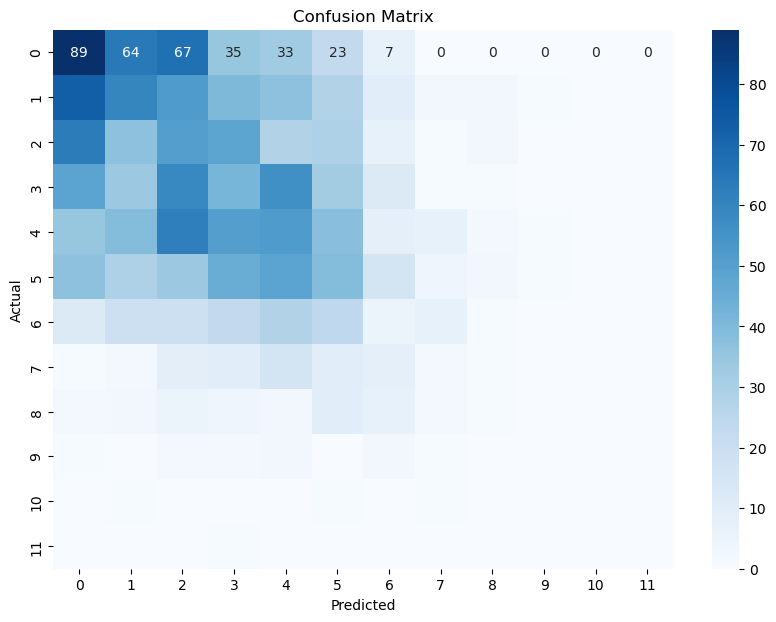

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         1.0       0.25      0.28      0.26       318
         2.0       0.21      0.20      0.20       307
         3.0       0.14      0.19      0.16       267
         4.0       0.14      0.15      0.14       286
         5.0       0.17      0.18      0.17       295
         6.0       0.17      0.15      0.16       257
         7.0       0.06      0.04      0.05       138
         8.0       0.07      0.03      0.05        59
         9.0       0.07      0.03      0.04        37
        10.0       0.00      0.00      0.00        12
        11.0       0.00      0.00      0.00         3
        12.0       0.00      0.00      0.00         1

    accuracy                           0.17      1980
   macro avg       0.11      0.10      0.10      1980
weighted avg       0.17      0.17      0.17      1980



c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Feature Importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

NameError: name 'np' is not defined